In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

1. Lage en tom testmappe i data mappen.
2. Legge til MURAv1.1 med train og valid mappene i data mappen.(kan slette de csv filene som følger med i MURA-v1.1) 
3. Kjøre scriptet "renaming_and_move_test_files"
4. Kjøre notebooken (edited)

# MURA

In [2]:
import sys
import os.path
sys.path.append("../../fastai/")

In [3]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn.metrics import confusion_matrix

/home/sathiesh/.conda/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sathiesh/.conda/envs/fastai/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/sathiesh/.conda/envs/fastai/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [4]:
# See how many devices are around
torch.cuda.device_count()
# Set it to a particular device
torch.cuda.set_device(0)
# Check which device you are on
torch.cuda.current_device()

0

In [5]:
NB_DIR = %pwd
PATH = f'{NB_DIR}/data/'

In [6]:
cleaned_label_path = f'{PATH}new_cleaned_label06.csv'

In [7]:
os.path.isfile(cleaned_label_path)

True

 # Hopp til load cleanled label hvis filen finnes fra før av

In [ ]:
df_train_image_paths = pd.read_csv(f'{PATH}train_image_paths.csv',header=None)
df_train_labeled_studies = pd.read_csv(f'{PATH}train_labeled_studies.csv', header=None)

In [ ]:
df_train_image_paths.columns = ['Image Index']

In [ ]:
df_train_labeled_studies.columns = ['Image Index', 'Abnormality']

In [ ]:
#finne indeksen 
df_train_image_paths['Abnormality'] = np.nan

In [ ]:
total = 0; 
for index, row in df_train_labeled_studies.iterrows():
    studie_name = row['Image Index']
    studie_abnormality = row['Abnormality']
    
    df = df_train_image_paths['Image Index'].str.contains(studie_name)
    df = df[df]
    idx_list = list(df.index)
    df_train_image_paths.loc[idx_list, 'Abnormality'] = studie_abnormality      
    total = total + len(idx_list);

In [ ]:
df_train_image_paths.shape, total

In [ ]:
df_train_image_paths.head()

In [ ]:
df_sorted = df_train_image_paths.pivot_table(index='Abnormality', aggfunc=len).sort_values('Image Index') 
df_sorted['Image Index'].plot(kind='bar', title="Normal vs abnormal")

In [ ]:
df_train_image_paths.to_csv(cleaned_label_path, index=False)

# Load cleaned label

In [8]:
df_train_image_paths = pd.read_csv(cleaned_label_path)

In [9]:
n = len(df_train_image_paths)-1
val_idxs = get_cv_idxs(n, val_pct=0.15) 

In [10]:
len(val_idxs)

4701

In [11]:
df_train_image_paths.shape

(31346, 2)

# View data

In [12]:
sz = 64
arch = dn121
bs = 32

In [13]:
def get_data(sz): 
    tfms = tfms_from_model(arch, sz, aug_tfms=transforms_side_on, max_zoom=1.1)
  #transforms_side_on
    return ImageClassifierData.from_csv(PATH ,'', cleaned_label_path , test_name='test', tfms=tfms, bs=bs, val_idxs = 0);

In [14]:
data = get_data(sz)

In [15]:
data.trn_ds.fnames.shape ,data.val_ds.fnames.shape

((31345,), (1,))

In [16]:
def get_augs(n):
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[n]

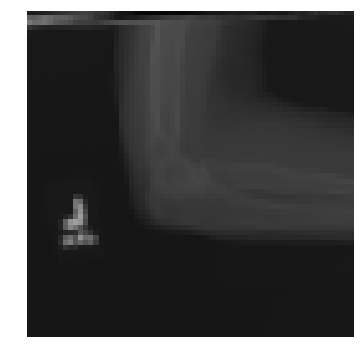

In [17]:
train_img1 = np.stack([get_augs(0) for i in range(1)])
plots(train_img1, rows=1)

# Training (hopp til prediction on test set)

In [18]:
learn = ConvLearner.pretrained(arch, data, ps = 0.5, opt_fn=optim.Adam) 

 68%|██████▊   | 669/980 [00:25<00:11, 26.09it/s, loss=2.28] 

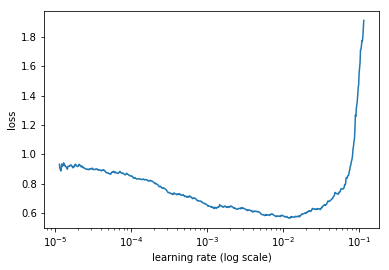

In [19]:
learn.lr_find()
learn.sched.plot()

In [20]:
lr = 0.001

In [21]:
learn.fit(lr,2, cycle_len=1, cycle_mult=2) 

epoch      trn_loss   val_loss   accuracy                    
    0      0.471938   0.154445   1.0       
    1      0.46899    0.174713   1.0                         
    2      0.445823   0.131864   1.0                         


[array([0.13186]), 1.0]

In [22]:
lrs = [lr/9, lr/3, lr] #TODO uten TL bør jeg dele på 9 og 3
learn.unfreeze()

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

 65%|██████▍   | 633/980 [01:06<00:36,  9.55it/s, loss=0.372]

In [ ]:
sz = 128

In [ ]:
learn.set_data(get_data(sz))
learn.freeze()

In [ ]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze();
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

In [ ]:
sz = 299

In [ ]:
learn.set_data(get_data(sz))
learn.freeze() 

In [ ]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.unfreeze()
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}1211')

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}1212')

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}1213')

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}1214')

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}1215')

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}1216')

In [ ]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)
learn.save(f'{sz}1217')

# Prediction on test set

In [153]:
sz = 299
data = get_data(sz)
learn = ConvLearner.pretrained(arch, data, ps = 0.4, opt_fn=optim.Adam) 
learn.load("299aug3") #299aug3 beste resultatet frem til nå

In [154]:
df_test = pd.read_csv(f'{PATH}valid_image_paths.csv', header=None)
df_test.columns = ['Image Index']

In [155]:
len(data.test_ds.fnames)

3197

In [156]:
df_test.head()

,Image Index
0,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
1,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
2,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
3,MURA-v1.1/valid/XR_WRIST/patient11185/study1_p...
4,MURA-v1.1/valid/XR_WRIST/patient11186/study1_p...


In [157]:
df_test.shape

(3197, 1)

In [158]:
df_test['Image Index'] = df_test['Image Index'].str.replace("MURA-v1.1/valid","test")
df_test['Image Index'] = df_test['Image Index'].str.replace("/", "_")
df_test['Image Index'] = df_test['Image Index'].str.replace("test_","test/")

In [159]:
patient_study_idxs = {}
for stud in df_test['Image Index']:
    study_name = stud[:-11]  #eksempel: studyname = test/XR_FOREARM_patient12044_study1_positive
    if study_name not in patient_study_idxs: 
        indices = [i for i, s in enumerate(data.test_ds.fnames) if study_name in s] #posisjonen til alle som 
        patient_study_idxs[study_name] = indices

In [160]:
len(patient_study_idxs)

1200

In [161]:
patient_study_y_label = {}
for key, value in patient_study_idxs.items():
    y_string = ([x.strip() for x in key.split('_')][-1])
    y=0
    if y_string == 'positive': y=1
    patient_study_y_label[key] = y

In [162]:
#lable alle testdataene for TTA
for index, val in enumerate(data.test_ds.fnames): 
    remove_char = 11
    study = val[:len(val)-remove_char]
    data.test_ds.y[index]= patient_study_y_label[study]

In [163]:
log_preds,y = learn.TTA(is_test=True)

In [164]:
correct = 0
total = 0
probs = np.mean(np.exp(log_preds),axis=0)
for index, preds in enumerate(probs): 
    prediction = np.argmax(preds)
    if prediction == y[index]: correct += 1
    total +=1    
accuracy = correct/len(y)

In [165]:
print('Accuracy with TTA: '+str(accuracy))

Accuracy with TTA: 0.792305286205818


### Predict studies 

In [166]:
trn_tfms, val_tfms = tfms_from_model(arch, sz) # get transformations
def predict_abnormality(fn): 
    im = open_image(fn)
    im_val = val_tfms(im)
    preds = learn.predict_array(im_val[None])
    return np.argmax(preds)

In [167]:
#value inneholder alle indeksene til et studie 
study_prediction_dict = {}
for key, value in patient_study_idxs.items(): 
    prediction_list = []    
    for img_pos in value: 
        prediction = predict_abnormality(PATH+data.test_ds.fnames[img_pos])
        prediction_list.append(prediction)
    study_prediction_dict[key] = max(prediction_list)

In [168]:
num_correct = 0;
wrong_prediction = {}
correct_prediction = {}
for key, value in study_prediction_dict.items(): 
    xr_type = ([x.strip() for x in key.split('_')][1]) #finne riktig 
    y = patient_study_y_label[key]
    if value == y: 
        num_correct +=1
        if xr_type not in correct_prediction: 
            correct_prediction[xr_type] = 1
        else: correct_prediction[xr_type] +=1
    else: 
        if xr_type not in wrong_prediction: 
            wrong_prediction[xr_type] = 1
        else:wrong_prediction[xr_type] +=1

In [169]:
test_accuracy = num_correct/len(study_prediction_dict)

In [170]:
print("case study accuracy: "+str(test_accuracy))

case study accuracy: 0.8166666666666667


In [171]:
correct_prediction

{'WRIST': 208,
 'FOREARM': 113,
 'HAND': 126,
 'HUMERUS': 116,
 'SHOULDER': 149,
 'ELBOW': 133,
 'FINGER': 135}

In [172]:
wrong_prediction

{'WRIST': 29,
 'FOREARM': 21,
 'HAND': 41,
 'HUMERUS': 19,
 'SHOULDER': 45,
 'ELBOW': 25,
 'FINGER': 40}

In [173]:
cm = confusion_matrix(list(patient_study_y_label.values()),list(study_prediction_dict.values()));

[[608  54]
 [166 372]]


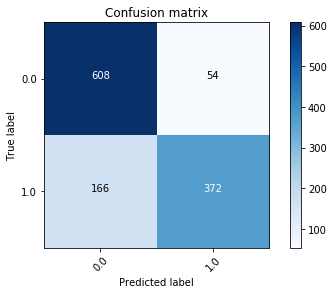

In [174]:
plot_confusion_matrix(cm, data.classes)

In [175]:
def cat_pred(correct, total): 
    return correct/total

In [176]:
for key,value in correct_prediction.items(): 
    total = value + wrong_prediction[key]
    acc = cat_pred(value, total)
    print("Accuracy for: " + key + ": " + str(acc) + "%")

Accuracy for: WRIST: 0.8776371308016878%
Accuracy for: FOREARM: 0.8432835820895522%
Accuracy for: HAND: 0.7544910179640718%
Accuracy for: HUMERUS: 0.8592592592592593%
Accuracy for: SHOULDER: 0.7680412371134021%
Accuracy for: ELBOW: 0.8417721518987342%
Accuracy for: FINGER: 0.7714285714285715%


In [177]:
from sklearn.metrics import cohen_kappa_score

In [178]:
chs = cohen_kappa_score(list(patient_study_y_label.values()),list(study_prediction_dict.values()))

In [179]:
chs

0.6220061166282945